In [1]:
# En primer lugar, consideraremos como banco de prueba la estación con mediciones más antiguas
# Se trata de la estacion localizada en Milan que tiene información desde 1763

import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

In [2]:
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import time

In [6]:
# Realizamos la query
station = 'ITE00100554'

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            date, 
                            TMAX, 
                            TMIN, 
                            PRCP
                        from world_time_europa
                        where STATION = '"""+station+"';")

n = 0
for r in rows:
    n = n+1
print("Numero de registros:" + str(n))

Numero de registros:89786


In [22]:
# Tenemos una serie temporal con un total de 89,786 registros, lo que para hacer un análisis inicial es un nivel 
# muy detallado por tanto, vamos a reducir el conjunto de datos realizando la media de cada unidad por año
# Realizamos la query
station = 'ITE00100554'
result=[]

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            substr(date,1,4) as date, 
                            avg(TMAX) as TMAX, 
                            avg(TMIN) as TMIN, 
                            avg(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_europa
                        where STATION = '"""+station+"""'
                        group by substr(date,1,4)
                        order by substr(date,1,4);""")
n = 0
for r in rows:
    n = n+1
    result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
    
print("Numero de registros:" + str(n))

Numero de registros:246


In [24]:
df = DataFrame(result)

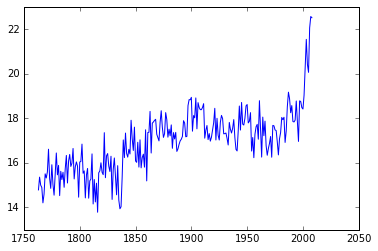

In [17]:
plt.plot(df.date,df.TMAX)

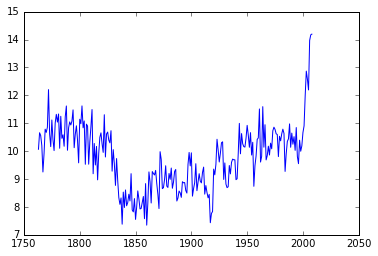

In [18]:
plt.plot(df.date,df.TMIN)

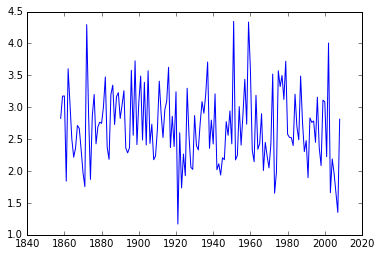

In [19]:
plt.plot(df.date,df.PRCP)

In [25]:
df.tail()

,NOBS,PRCP,TMAX,TMIN,date
241,366,2.189617,20.412251,12.578632,2004
242,365,1.962192,20.053889,12.191944,2005
243,365,1.655342,22.047397,13.967123,2006
244,331,1.350909,22.555891,14.167372,2007
245,336,2.813095,22.501791,14.192836,2008


Se observa que efectivamente en los últimos años de la serie se presentan anomalías en los 3 indicadores, 
pero no tenemos la información completa, ya que el último dato disponible de la estación data de 2008, 
por tanto tenemos que localizar una estacion en una localización con similares características para poder
extrapolar las medidas de la estación de Milan con esa nueva localizacion.  

¿Desde que fecha debemos completar?

La serie se trunca en 2008, pero los datos anómalos que se observan desde 2006 parecen indicar anomalias en las
observaciones, ya que rompe totalmente y muy bruscamente los datos.  Si observamos la serie histórica, cada año
hay 365 o 366 observaciones, salvo en los años de 2007 y 2008 que presentan 331 y 336 observaciones respectivamente,
es decir que falta al menos 1 mes de observaciones, si esa falta estuviera distribuida uniformemente por todo el año
podríamos inferir que la anomalía no es debida a esa falta de información, pero si sacamos el número de observaciones
por mes, vemos que en 2007 faltan 4 días de Julio y 30 de Octubre, un mes en el que las temperaturas se reducen,
por tanto podría explicar la subida en la temperatura media anual en 2 grados

Para 2008, se observa que faltan 30 días de Diciembre, el primer mes de invierno, que puede explicar el incremento
observado en temperaturas y reducción de precipitaciones

En 2006, a pesar de ser el primer año con anomalías, parece que no es debido al tamaño de los datos, por tanto
consideraremos que ese año la información es correcta.  Por tanto para completar la información de la serie de Milan
debemos buscar las observaciones de la estacion meteorológica más parecida desde el año 2007

In [31]:
# Para los años 2007 y 2008 revisamos qué días del año faltan
station = 'ITE00100554'

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            substr(date,1,6) as date, 
                            count(*) as NOBS
                        from world_time_europa
                        where STATION = '"""+station+"""' and date >= "20070101" and date <= "20081231"
                        group by substr(date,1,6)
                        order by substr(date,1,6);""")
result_2007=[]
result_2008=[]
for r in rows:
    if r[0] <= "200712":
        result_2007.append({"date":r[0],"NOBS":r[1]})
    else:
        result_2008.append({"date":r[0],"NOBS":r[1]})

In [32]:
df_2007 = DataFrame(result_2007)
df_2008 = DataFrame(result_2008)

In [33]:
df_2007

,NOBS,date
0,31,200701
1,28,200702
2,31,200703
3,30,200704
4,31,200705
5,30,200706
6,27,200707
7,31,200708
8,30,200709
9,1,200710


In [34]:
df_2008

,NOBS,date
0,31,200801
1,29,200802
2,31,200803
3,30,200804
4,31,200805
5,30,200806
6,31,200807
7,31,200808
8,30,200809
9,31,200810


En ambos casos falta información de 1 mes de otoño/invierno, justo cuando las temperaturas son más bajas, por tanto 
los picos observados en 2007 y 2008 no son válidos

Por simplicidad, vamos a considerar los mismos indicadores pero para cada cada continente, para ver si a nivel global se observa alguna tendencia

In [18]:
# Comenzamos con europa y a continuación extrapolaremos para el resto de continentes
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            substr(date,1,4) as date, 
                            avg(TMAX) as TMAX, 
                            avg(TMIN) as TMIN, 
                            avg(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        group by substr(date,1,4)
                        order by substr(date,1,4);""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    df_europa = DataFrame(result)

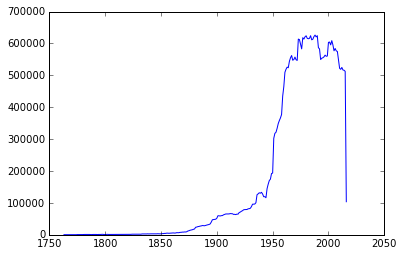

In [19]:
plt.plot(df_europa.date,df_europa.NOBS)

Se obserba que el número de estaciones no es constante a lo largo de la historia, se van incluyendo nuevas estaciones
de medicion, principalmente a partir de 1950.  Como nuestro estudio trata de ver una variación significativa en
la evolución temporal, debemos tener al menos 100 años de observaciones de cada estacion, para determinar un patrón,
para ello realizamos la query necesaria para quedarnos con las observaciones de las estaciones más antiguas, es
decir, existentes en 1900

In [22]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se recuperan todas las estaciones del continentes que existían en Enero de 1900
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})
    
    # La lista de estaciones la convertimos en un DataFrame
    station_list_1900 = DataFrame(station_list_1900)
    
    # Se compone la lista de estaciones para que lo entienda SQL
    stations = ""
    for s in station_list_1900.as_matrix():
        if stations != "":
            stations = stations + ","
        stations = stations + "'" + s[0] + "'"
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            date, 
                            sum(TMAX) as TMAX, 
                            sum(TMIN) as TMIN, 
                            sum(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by date
                        order by date;""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    if cont == "europa":
        df_europa = DataFrame(result)
        
# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: x[:4])
# Se realiza el group by por año
df_europa_agg = df_europa.groupby('year').sum()
# Se recalculan los indicadores
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.TMAX = df_europa_agg.TMAX/df_europa_agg.NOBS
df_europa_agg.TMIN = df_europa_agg.TMIN/df_europa_agg.NOBS
df_europa_agg.PRCP = df_europa_agg.PRCP/df_europa_agg.NOBS

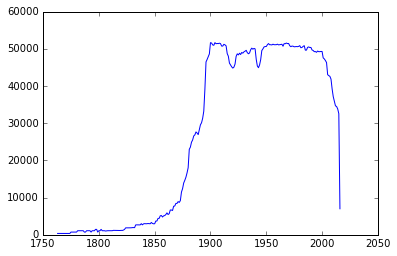

In [24]:
# Se representa la evolución del número de observaciones desde 1900
plt.plot(df_europa_agg.year,df_europa_agg.NOBS)

Se observa que algunas estaciones dejan de proveer información, por tanto nos interesan únicamente aquellas
que siguen existiendo en 2016, más concretamente en Abril de 2016

In [25]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se recuperan todas las estaciones del continentes que existían previamente a 1900 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})

    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
    station_list_2016 = []
    for r in rows:
        station_list_2016.append({"station":r[0]})

    station_list_1900 = DataFrame(station_list_1900)
    station_list_2016 = DataFrame(station_list_2016)

    # Nos quedamos con las estaciones que estan en ambas listas
    station_list = station_list_1900.merge(station_list_2016)
    station_list = station_list.reset_index()
    
    # Se compone la lista de estaciones para que lo entienda SQL
    stations = ""
    for s in station_list.as_matrix():
        if stations != "":
            stations = stations + ","
        stations = stations + "'" + s[1] + "'"
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            date, 
                            sum(TMAX) as TMAX, 
                            sum(TMIN) as TMIN, 
                            sum(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by date
                        order by date;""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    if cont == "europa":
        df_europa = DataFrame(result)

# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: x[:4])
# Se realiza el group by por año
df_europa_agg = df_europa.groupby('year').sum()
# Se recalculan los indicadores
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.TMAX = df_europa_agg.TMAX/df_europa_agg.NOBS
df_europa_agg.TMIN = df_europa_agg.TMIN/df_europa_agg.NOBS
df_europa_agg.PRCP = df_europa_agg.PRCP/df_europa_agg.NOBS

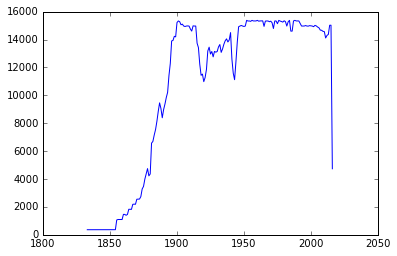

In [26]:
# Se representa la evolución del número de observaciones desde 1900
plt.plot(df_europa_agg.year,df_agg.NOBS)

Aun así en la primera parte del siglo XX se observa que algunas estaciones dejan de proporcionar datos, para a continuación empezar a volver a generarlos a partir de 1950, por las fechas, parecería ser debido a las guerras mundiales, debemos eliminar dichas estaciones

In [39]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se recuperan todas las estaciones del continentes que existían previamente a 1900 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})

    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
    station_list_2016 = []
    for r in rows:
        station_list_2016.append({"station":r[0]})

    station_list_1900 = DataFrame(station_list_1900)
    station_list_2016 = DataFrame(station_list_2016)

    # Nos quedamos con las estaciones que estan en ambas listas
    station_list = station_list_1900.merge(station_list_2016)
    station_list = station_list.reset_index()
    
    # Se compone la lista de estaciones para que lo entienda SQL
    stations = ""
    for s in station_list.as_matrix():
        if stations != "":
            stations = stations + ","
        stations = stations + "'" + s[1] + "'"
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            station,
                            date
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by station, date
                        order by station, date;""")
    result=[]
    for r in rows:
        result.append({"station":r[0],"date":r[1]})
   
    if cont == "europa":
        df_europa = DataFrame(result)

# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: int(x[:4]))

# Nos quedamos con las observaciones a partir de 1900
df_europa = df_europa[df_europa.year >= 1900]

# Analizamos el numero de observaciones por estacion
df_europa['n'] = 1
df_europa_agg = df_europa.groupby(["station","year"]).sum()
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.to_csv("estaciones.csv")

Tras analizar el resultado y limpiar todas aquellas estaciones con huecos en su historia, nos quedamos finalmente
con las siguientes estaciones: 
AU000005010
AU000005901
AU000011801
EI000003969
GM000010147
HR000142360
NLM00006310
NOE00110029
NOE00111120
NOE00111129
SIM00014015


In [74]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:    
    stations = """'AU000005010','AU000005901','AU000011801','EI000003969','GM000010147','HR000142360',
                  'NLM00006310','NOE00110029','NOE00111120','NOE00111129','SIM00014015'"""
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            date, 
                            sum(TMAX) as TMAX, 
                            sum(TMIN) as TMIN, 
                            sum(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by date
                        order by date;""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    if cont == "europa":
        df_europa = DataFrame(result)

# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: x[:4])
# Se realiza el group by por año
df_europa_agg = df_europa.groupby('year').sum()
# Se recalculan los indicadores
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.TMAX = df_europa_agg.TMAX/df_europa_agg.NOBS
df_europa_agg.TMIN = df_europa_agg.TMIN/df_europa_agg.NOBS
df_europa_agg.PRCP = df_europa_agg.PRCP/df_europa_agg.NOBS

In [75]:
df_europa_agg = df_europa_agg[df_europa_agg['year'] >= "1900"]

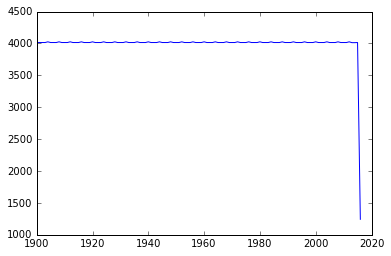

In [77]:
plt.plot(df_europa_agg.year, df_europa_agg.NOBS)

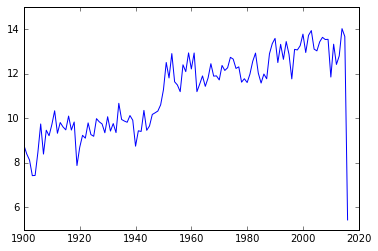

In [76]:
plt.plot(df_europa_agg.year, df_europa_agg.TMAX)

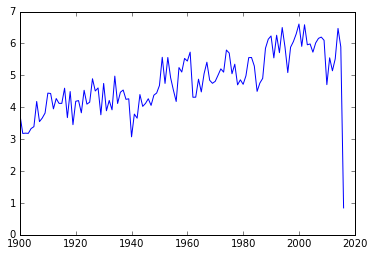

In [78]:
plt.plot(df_europa_agg.year, df_europa_agg.TMIN)

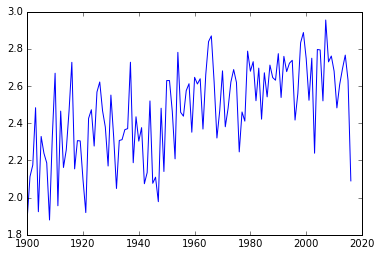

In [81]:
plt.plot(df_europa_agg.year, df_europa_agg.PRCP)

In [3]:
# Vamos a intentar automatizar el análisis anterior, es decir, considerar los datos a partir de cierto año y a 
# continuacion filtrar por aquellas estaciones que tienen observaciones por año inferior a 364 dias
df_total = DataFrame()
#continentes=["europa"]
continentes=["antarctica","central_america","south_america","europa","africa","asia","oceania","north_america"]

for cont in continentes:
    print("Inicio continente: " + cont + " a las " + str(time.strftime("%H:%M:%S")))
    # Se recuperan todas las estaciones del continentes que existían previamente a 1900 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})
        
    if len(station_list_1900) > 0:
        rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
        station_list_2016 = []
        for r in rows:
            station_list_2016.append({"station":r[0]})

        station_list_1900 = DataFrame(station_list_1900)
        station_list_2016 = DataFrame(station_list_2016)

        # Nos quedamos con las estaciones que estan en ambas listas

        station_list = station_list_1900.merge(station_list_2016)
        station_list = station_list.reset_index()

        if len(station_list) > 0:
            # Se compone la lista de estaciones para que lo entienda SQL, se seleccionan bloques de 500 estaciones
            stations = []
            stats = ""
            n = 0;
            for s in station_list.as_matrix():
                n = n + 1
                if stats != "":
                    stats = stats + ","
                stats = stats + "'" + s[1] + "'"
                
                if n % 100 == 0:
                    stations.append(stats)
                    stats = ""
                    
            if stats != "":
                stations.append(stats)

            # Se itera para cada uno de los bloques de 100 estaciones
            n_lote = 0
            while n_lote < len(stations):
                print ("   Iteracion sobre el bloque " + str(n_lote) + " de 100 estaciones de " + str(len(stations)))
                rows = cursor.execute("""select 
                                        station,
                                        date,
                                        sum(TMAX) as TMAX, 
                                        sum(TMIN) as TMIN, 
                                        sum(PRCP) as PRCP,
                                        count(*) as NOBS
                                    from world_time_"""+cont+""" 
                                    where station in ("""+stations[n_lote]+""") 
                                    group by station, date
                                    order by station, date;""")                

                result=[]           
                for r in rows:
                    if int(r[1][:4]) >= 1900:
                        result.append({"station":r[0],"date":r[1],"TMAX":r[2],"TMIN":r[3],"PRCP":r[4],"NOBS":r[5]})

                df = DataFrame(result)
                
                result = []
                n_lote = n_lote+1

                # Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas 
                # fuera del SQL
                # Se calcula el año a partir de la fecha
                df['year'] = df.date.map(lambda x: int(x[:4]))

                # Analizamos el numero de observaciones por estacion
                df['n'] = 1
                df_agg = df.groupby(["station","year"]).sum()
                df_agg = df_agg.reset_index()
                df = DataFrame()

                # Identificamos todas aquellas estaciones que tienen años con un numero de observaciones inferior 
                # a 364, excluyendo para ello el año 2016 (que no esta completo)
                df_falta_datos = df_agg[df_agg.n < 364]
                df_falta_datos = df_falta_datos[df_falta_datos.year != 2016]
                df_falta_datos = df_falta_datos.drop_duplicates("station")

                # Se eliminan las estaciones identificadas
                for s in df_falta_datos.station:
                    df_agg = df_agg[df_agg.station != s]

                # Se eliminan las variables no necesarias
                df_agg = df_agg[['station','year','TMAX','TMIN','PRCP','NOBS']]

                # Es necesario eliminar las series que tienen un año completo sin datos

                # Agregamos los indicadores por estacion
                df_agg_2 = df_agg.groupby('station').count()

                # Identificamos aquellas estaciones que no llegan al número de años que deberían tener
                if len(df_agg_2) > 0:
                    df_agg_2 = df_agg_2[df_agg_2.year < max(df_agg_2.year)]

                df_agg_2 = df_agg_2.reset_index()[['station']]

                # Eliminamos las estaciones identificadas
                for s in df_agg_2.station:
                    df_agg = df_agg[df_agg.station != s]

                df_agg_2 = DataFrame()
                # Agregamos los indicadores por año
                df_agg = df_agg.groupby('year').sum()
                df_agg = df_agg.reset_index()
                
                df_agg['continent'] = cont
                
                df_total = df_total.append(df_agg)
                df_agg = DataFrame()
                df_total.to_csv("Resultado_calentamiento.csv")
    
    print("Fin continente: " + cont)    
    
    df_total.to_csv("Resultado_calentamiento.csv")
conn.close()

# Una vez iterados por todos los continentes, se realiza una agrupacion por continente y año para obtener los 
# indicadores esperados

df_total = df_total.groupby(['continent','year']).sum()
df_total = df_total.reset_index()

# Nos quedamos con las observaciones posteriores a 1900
df_total = df_total[df_total.year >= 1900]

# Se calculan los indicadores
df_total.TMAX = df_total.TMAX/df_total.NOBS
df_total.TMIN = df_total.TMIN/df_total.NOBS
df_total.PRCP = df_total.PRCP/df_total.NOBS

# Se almacena el resultado final
df_total.to_csv("Resultado_calentamiento.csv")


Inicio continente: antarctica a las 20:06:51
Fin continente: antarctica
Inicio continente: central_america a las 20:06:51
Fin continente: central_america
Inicio continente: south_america a las 20:06:51
Fin continente: south_america
Inicio continente: europa a las 20:06:51
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: europa
Inicio continente: africa a las 20:10:13
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: africa
Inicio continente: asia a las 20:11:49
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: asia
Inicio continente: oceania a las 20:19:04
   Iteracion sobre el bloque 0 de 100 estaciones de 5
   Iteracion sobre el bloque 1 de 100 estaciones de 5
   Iteracion sobre el bloque 2 de 100 estaciones de 5
   Iteracion sobre el bloque 3 de 100 estaciones de 5
   Iteracion sobre el bloque 4 de 100 estaciones de 5
Fin continente: oceania
Inicio continente: north_america a las 21:19:13
   Iteracion sobre el bloque 0 de 

In [2]:
import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

# Vamos a intentar automatizar el análisis anterior, es decir, considerar los datos a partir de cierto año y a 
# continuacion filtrar por aquellas estaciones que tienen observaciones por año inferior a 364 dias
df_total = DataFrame()
#continentes=["europa"]
continentes=["antarctica","central_america","south_america","europa","africa","asia","oceania","north_america"]

for cont in continentes:
    print("Inicio continente: " + cont + " a las " + str(time.strftime("%H:%M:%S")))
    # Se recuperan todas las estaciones del continentes que existían previamente a 1970 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19700101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})
        
    if len(station_list_1900) > 0:
        rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
        station_list_2016 = []
        for r in rows:
            station_list_2016.append({"station":r[0]})

        station_list_1900 = DataFrame(station_list_1900)
        station_list_2016 = DataFrame(station_list_2016)

        # Nos quedamos con las estaciones que estan en ambas listas

        station_list = station_list_1900.merge(station_list_2016)
        station_list = station_list.reset_index()

        if len(station_list) > 0:
            # Se compone la lista de estaciones para que lo entienda SQL, se seleccionan bloques de 500 estaciones
            stations = []
            stats = ""
            n = 0;
            for s in station_list.as_matrix():
                n = n + 1
                if stats != "":
                    stats = stats + ","
                stats = stats + "'" + s[1] + "'"
                
                if n % 500 == 0:
                    stations.append(stats)
                    stats = ""
                    
            if stats != "":
                stations.append(stats)

            # Se itera para cada uno de los bloques de 100 estaciones
            n_lote = 0
            while n_lote < len(stations):
                print ("   Iteracion sobre el bloque " + str(n_lote) + " de 500 estaciones de "+str(len(stations)) + " bloques")
                rows = cursor.execute("""select 
                                        station,
                                        date,
                                        sum(TMAX) as TMAX, 
                                        sum(TMIN) as TMIN, 
                                        sum(PRCP) as PRCP,
                                        count(*) as NOBS
                                    from world_time_"""+cont+""" 
                                    where station in ("""+stations[n_lote]+""") 
                                    group by station, date
                                    order by station, date;""")                

                result=[]           
                for r in rows:
                    if int(r[1][:4]) >= 1970:
                        result.append({"station":r[0],"date":r[1],"TMAX":r[2],"TMIN":r[3],"PRCP":r[4],"NOBS":r[5]})

                df = DataFrame(result)
                
                result = []
                n_lote = n_lote+1

                # Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas 
                # fuera del SQL
                # Se calcula el año a partir de la fecha
                df['year'] = df.date.map(lambda x: int(x[:4]))

                # Analizamos el numero de observaciones por estacion
                df['n'] = 1
                df_agg = df.groupby(["station","year"]).sum()
                df_agg = df_agg.reset_index()
                df = DataFrame()

                # Identificamos todas aquellas estaciones que tienen años con un numero de observaciones inferior 
                # a 364, excluyendo para ello el año 2016 (que no esta completo)
                df_falta_datos = df_agg[df_agg.n < 364]
                df_falta_datos = df_falta_datos[df_falta_datos.year != 2016]
                df_falta_datos = df_falta_datos.drop_duplicates("station")

                # Se eliminan las estaciones identificadas
                for s in df_falta_datos.station:
                    df_agg = df_agg[df_agg.station != s]

                df_falta_datos = DataFrame()
                
                # Se eliminan las variables no necesarias
                df_agg = df_agg[['station','year','TMAX','TMIN','PRCP','NOBS']]

                # Es necesario eliminar las series que tienen un año completo sin datos

                # Agregamos los indicadores por estacion
                df_agg_2 = df_agg.groupby('station').count()

                # Identificamos aquellas estaciones que no llegan al número de años que deberían tener
                if len(df_agg_2) > 0:
                    df_agg_2 = df_agg_2[df_agg_2.year < max(df_agg_2.year)]

                df_agg_2 = df_agg_2.reset_index()[['station']]

                # Eliminamos las estaciones identificadas
                for s in df_agg_2.station:
                    df_agg = df_agg[df_agg.station != s]

                df_agg_2 = DataFrame()
                
                # Agregamos los indicadores por año
                df_agg = df_agg.groupby('year').sum()
                df_agg = df_agg.reset_index()
                
                # Se calculan los indicadores
                df_agg['continent'] = cont
                
                df_total = df_total.append(df_agg)
                df_total.to_csv("Resultado_calentamiento_1970_1.csv")
                df_agg = DataFrame()
    
    print("Fin continente: " + cont)
    
    df_total.to_csv("Resultado_calentamiento_1970_1.csv")
conn.close()

# Una vez iterados por todos los continentes, se realiza una agrupacion por continente y año para obtener los 
# indicadores esperados

df_total = df_total.groupby(['continent','year']).sum()
df_total = df_total.reset_index()

# Nos quedamos con las observaciones posteriores a 1900
df_total = df_total[df_total.year >= 1970]

# Se calculan los indicadores
df_total.TMAX = df_total.TMAX/df_total.NOBS
df_total.TMIN = df_total.TMIN/df_total.NOBS
df_total.PRCP = df_total.PRCP/df_total.NOBS

# Se almacena el resultado final
df_total.to_csv("Resultado_calentamiento_1970.csv")


Inicio continente: antarctica a las 23:40:06
   Iteracion sobre el bloque 0 de 100 estaciones de 1 bloques
Fin continente: antarctica
Inicio continente: central_america a las 23:40:15
   Iteracion sobre el bloque 0 de 100 estaciones de 1 bloques
Fin continente: central_america
Inicio continente: south_america a las 23:40:25
   Iteracion sobre el bloque 0 de 100 estaciones de 1 bloques
Fin continente: south_america
Inicio continente: europa a las 23:43:07
   Iteracion sobre el bloque 0 de 100 estaciones de 1 bloques
Fin continente: europa
Inicio continente: africa a las 00:05:21
   Iteracion sobre el bloque 0 de 100 estaciones de 1 bloques
Fin continente: africa
Inicio continente: asia a las 00:11:14
   Iteracion sobre el bloque 0 de 100 estaciones de 3 bloques
   Iteracion sobre el bloque 1 de 100 estaciones de 3 bloques
   Iteracion sobre el bloque 2 de 100 estaciones de 3 bloques
Fin continente: asia
Inicio continente: oceania a las 01:31:42
   Iteracion sobre el bloque 0 de 100 esta

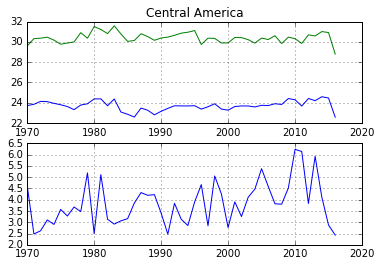

In [33]:
plt.figure(1)
df = df_total[df_total.continent=='central_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Central America')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

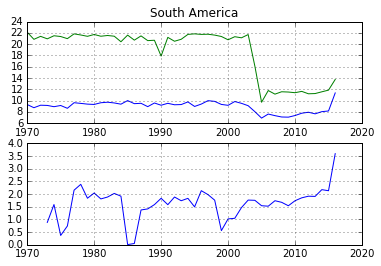

In [34]:
plt.figure(1)
df = df_total[df_total.continent=='south_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('South America')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

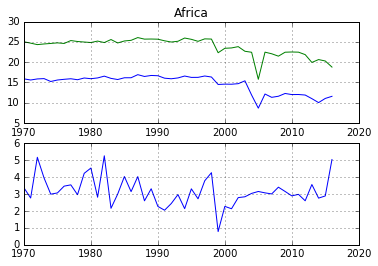

In [35]:
plt.figure(1)
df = df_total[df_total.continent=='africa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Africa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

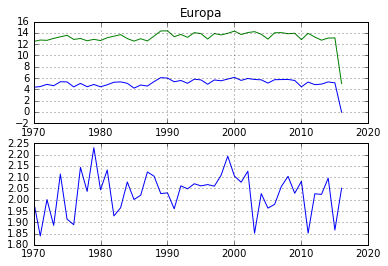

In [36]:
plt.figure(1)
df = df_total[df_total.continent=='europa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Europa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

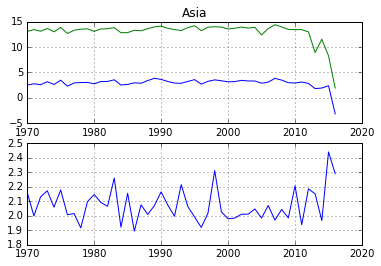

In [37]:
plt.figure(1)
df = df_total[df_total.continent=='asia']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Asia')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

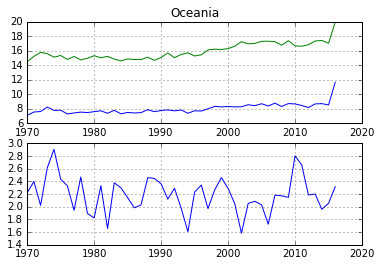

In [38]:
plt.figure(1)
df = df_total[df_total.continent=='oceania']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Oceania')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

Debido a la evolucion de las series temporales de Sur America, se ha investigado que sucede y es que en muchas estaciones hay observaciones en cada dia del año pero no para todas las medidas, dias que tienen solo precipitaciones, solo temperatura maxima o la minima.  Como esto es fuente de problema, vamos a realizar el mismo analisis anterior, pero eliminando todos aquellos registros que tengan la temperatura maxima o minima como nulo, la precipitacion como es menos importante para este analisis convertimos un nulo a 0

In [3]:
conn.close()

In [ ]:
import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

# Vamos a intentar automatizar el análisis anterior, es decir, considerar los datos a partir de cierto año y a 
# continuacion filtrar por aquellas estaciones que tienen observaciones por año inferior a 364 dias
df_total = DataFrame()
#continentes=["europa"]
continentes=["antarctica","central_america","south_america","europa","africa","asia","oceania","north_america"]

for cont in continentes:
    print("Inicio continente: " + cont + " a las " + str(time.strftime("%H:%M:%S")))
    # Se recuperan todas las estaciones del continentes que existían previamente a 1970 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19700101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})
        
    if len(station_list_1900) > 0:
        rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
        station_list_2016 = []
        for r in rows:
            station_list_2016.append({"station":r[0]})

        station_list_1900 = DataFrame(station_list_1900)
        station_list_2016 = DataFrame(station_list_2016)

        # Nos quedamos con las estaciones que estan en ambas listas

        station_list = station_list_1900.merge(station_list_2016)
        station_list = station_list.reset_index()

        if len(station_list) > 0:
            # Se compone la lista de estaciones para que lo entienda SQL, se seleccionan bloques de 500 estaciones
            stations = []
            stats = ""
            n = 0;
            for s in station_list.as_matrix():
                n = n + 1
                if stats != "":
                    stats = stats + ","
                stats = stats + "'" + s[1] + "'"
                
                if n % 500 == 0:
                    stations.append(stats)
                    stats = ""
                    
            if stats != "":
                stations.append(stats)

            # Se itera para cada uno de los bloques de 100 estaciones
            n_lote = 0
            while n_lote < len(stations):
                print ("   Iteracion sobre el bloque " + str(n_lote) + " de 500 estaciones de "+str(len(stations)) + " bloques")
                rows = cursor.execute("""select 
                                        station,
                                        date,
                                        sum(TMAX) as TMAX, 
                                        sum(TMIN) as TMIN, 
                                        sum(PRCP) as PRCP,
                                        count(*) as NOBS
                                    from world_time_"""+cont+""" 
                                    where station in ("""+stations[n_lote]+""") 
                                    group by station, date
                                    order by station, date;""")                

                result=[]           
                for r in rows:
                    if int(r[1][:4]) >= 1970:
                        result.append({"station":r[0],"date":r[1],"TMAX":r[2],"TMIN":r[3],"PRCP":r[4],"NOBS":r[5]})

                df = DataFrame(result)
                
                result = []
                n_lote = n_lote+1
                
                # Se inicializa a 0 todos los NaN en precipitaciones
                df.PRCP = df.PRCP.fillna(0)
                # Se eliminan los registros con valores nulos en temperatura maxima y minima
                df = df.dropna()

                # Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas 
                # fuera del SQL
                # Se calcula el año a partir de la fecha
                df['year'] = df.date.map(lambda x: int(x[:4]))

                # Analizamos el numero de observaciones por estacion
                df['n'] = 1
                df_agg = df.groupby(["station","year"]).sum()
                df_agg = df_agg.reset_index()
                df = DataFrame()

                # Identificamos todas aquellas estaciones que tienen años con un numero de observaciones inferior 
                # a 364, excluyendo para ello el año 2016 (que no esta completo)
                df_falta_datos = df_agg[df_agg.n < 364]
                df_falta_datos = df_falta_datos[df_falta_datos.year != 2016]
                df_falta_datos = df_falta_datos.drop_duplicates("station")

                # Se eliminan las estaciones identificadas
                for s in df_falta_datos.station:
                    df_agg = df_agg[df_agg.station != s]

                df_falta_datos = DataFrame()
                
                # Se eliminan las variables no necesarias
                df_agg = df_agg[['station','year','TMAX','TMIN','PRCP','NOBS']]

                # Es necesario eliminar las series que tienen un año completo sin datos

                # Agregamos los indicadores por estacion
                df_agg_2 = df_agg.groupby('station').count()

                # Identificamos aquellas estaciones que no llegan al número de años que deberían tener
                if len(df_agg_2) > 0:
                    df_agg_2 = df_agg_2[df_agg_2.year < max(df_agg_2.year)]

                df_agg_2 = df_agg_2.reset_index()[['station']]

                # Eliminamos las estaciones identificadas
                for s in df_agg_2.station:
                    df_agg = df_agg[df_agg.station != s]

                df_agg_2 = DataFrame()
                
                # Agregamos los indicadores por año
                df_agg = df_agg.groupby('year').sum()
                df_agg = df_agg.reset_index()
                
                # Se calculan los indicadores
                df_agg['continent'] = cont
                
                df_total = df_total.append(df_agg)
                df_total.to_csv("Resultado_calentamiento_1970_1.csv")
                df_agg = DataFrame()
    
    print("Fin continente: " + cont)
    
    df_total.to_csv("Resultado_calentamiento_1970_1.csv")
conn.close()

# Una vez iterados por todos los continentes, se realiza una agrupacion por continente y año para obtener los 
# indicadores esperados

df_total = df_total.groupby(['continent','year']).sum()
df_total = df_total.reset_index()

# Nos quedamos con las observaciones posteriores a 1900
df_total = df_total[df_total.year >= 1970]

# Se calculan los indicadores
df_total.TMAX = df_total.TMAX/df_total.NOBS
df_total.TMIN = df_total.TMIN/df_total.NOBS
df_total.PRCP = df_total.PRCP/df_total.NOBS

# Se almacena el resultado final
df_total.to_csv("Resultado_calentamiento_1970.csv")
conn.close()

Inicio continente: antarctica a las 10:27:19
   Iteracion sobre el bloque 0 de 500 estaciones de 1 bloques
Fin continente: antarctica
Inicio continente: central_america a las 10:27:29
   Iteracion sobre el bloque 0 de 500 estaciones de 1 bloques
Fin continente: central_america
Inicio continente: south_america a las 10:27:39
   Iteracion sobre el bloque 0 de 500 estaciones de 1 bloques
Fin continente: south_america
Inicio continente: europa a las 10:28:05
   Iteracion sobre el bloque 0 de 500 estaciones de 1 bloques
Fin continente: europa
Inicio continente: africa a las 10:58:06
   Iteracion sobre el bloque 0 de 500 estaciones de 1 bloques
Fin continente: africa
Inicio continente: asia a las 11:04:44
   Iteracion sobre el bloque 0 de 500 estaciones de 3 bloques
   Iteracion sobre el bloque 1 de 500 estaciones de 3 bloques
   Iteracion sobre el bloque 2 de 500 estaciones de 3 bloques
Fin continente: asia
Inicio continente: oceania a las 12:43:23
   Iteracion sobre el bloque 0 de 500 esta

In [ ]:
import pandas as pd
from pandas import Series,DataFrame
df_total = pd.read_csv("Resultado_calentamiento_1970_1.csv")
df_total =df_total[['year','TMAX','TMIN','PRCP','NOBS','continent']]
df_total.head()

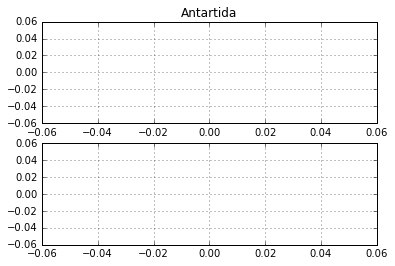

In [7]:
plt.figure(1)
df = df_total[df_total.continent=='antarctica']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Antartida')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='north_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('America del Norte')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='central_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('America Central')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='south_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('America del Sur')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='europa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Europa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='Africa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Africa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='asia']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Asia')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [ ]:
plt.figure(1)
df = df_total[df_total.continent=='oceania']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Oceania')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

In [6]:
import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

# Vamos a intentar automatizar el análisis anterior, es decir, considerar los datos a partir de cierto año y a 
# continuacion filtrar por aquellas estaciones que tienen observaciones por año inferior a 364 dias
df_total = DataFrame()
#continentes=["europa"]
continentes=["antarctica","central_america","south_america","europa","africa","asia","oceania","north_america"]

for cont in continentes:
    print("Inicio continente: " + cont + " a las " + str(time.strftime("%H:%M:%S")))
    # Se recuperan todas las estaciones del continentes que existían previamente a 1900 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})
        
    if len(station_list_1900) > 0:
        rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
        station_list_2016 = []
        for r in rows:
            station_list_2016.append({"station":r[0]})

        station_list_1900 = DataFrame(station_list_1900)
        station_list_2016 = DataFrame(station_list_2016)

        # Nos quedamos con las estaciones que estan en ambas listas

        station_list = station_list_1900.merge(station_list_2016)
        station_list = station_list.reset_index()

        if len(station_list) > 0:
            # Se compone la lista de estaciones para que lo entienda SQL, se seleccionan bloques de 500 estaciones
            stations = []
            stats = ""
            n = 0;
            for s in station_list.as_matrix():
                n = n + 1
                if stats != "":
                    stats = stats + ","
                stats = stats + "'" + s[1] + "'"
                
                if n % 100 == 0:
                    stations.append(stats)
                    stats = ""
                    
            if stats != "":
                stations.append(stats)

            # Se itera para cada uno de los bloques de 100 estaciones
            n_lote = 0
            while n_lote < len(stations):
                print ("   Iteracion sobre el bloque " + str(n_lote) + " de 100 estaciones de " + str(len(stations)))
                rows = cursor.execute("""select 
                                        station,
                                        date,
                                        sum(TMAX) as TMAX, 
                                        sum(TMIN) as TMIN, 
                                        sum(PRCP) as PRCP,
                                        count(*) as NOBS
                                    from world_time_"""+cont+""" 
                                    where station in ("""+stations[n_lote]+""") 
                                    group by station, date
                                    order by station, date;""")                

                result=[]           
                for r in rows:
                    if int(r[1][:4]) >= 1900:
                        result.append({"station":r[0],"date":r[1],"TMAX":r[2],"TMIN":r[3],"PRCP":r[4],"NOBS":r[5]})

                df = DataFrame(result)
                
                result = []
                n_lote = n_lote+1
                
                df.PRCP = df.PRCP.fillna(0)
                df = df.dropna()

                # Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas 
                # fuera del SQL
                # Se calcula el año a partir de la fecha
                df['year'] = df.date.map(lambda x: int(x[:4]))

                # Analizamos el numero de observaciones por estacion
                df['n'] = 1
                df_agg = df.groupby(["station","year"]).sum()
                df_agg = df_agg.reset_index()
                df = DataFrame()

                # Identificamos todas aquellas estaciones que tienen años con un numero de observaciones inferior 
                # a 364, excluyendo para ello el año 2016 (que no esta completo)
                df_falta_datos = df_agg[df_agg.n < 364]
                df_falta_datos = df_falta_datos[df_falta_datos.year != 2016]
                df_falta_datos = df_falta_datos.drop_duplicates("station")

                # Se eliminan las estaciones identificadas
                for s in df_falta_datos.station:
                    df_agg = df_agg[df_agg.station != s]

                # Se eliminan las variables no necesarias
                df_agg = df_agg[['station','year','TMAX','TMIN','PRCP','NOBS']]

                # Es necesario eliminar las series que tienen un año completo sin datos

                # Agregamos los indicadores por estacion
                df_agg_2 = df_agg.groupby('station').count()

                # Identificamos aquellas estaciones que no llegan al número de años que deberían tener
                if len(df_agg_2) > 0:
                    df_agg_2 = df_agg_2[df_agg_2.year < max(df_agg_2.year)]

                df_agg_2 = df_agg_2.reset_index()[['station']]

                # Eliminamos las estaciones identificadas
                for s in df_agg_2.station:
                    df_agg = df_agg[df_agg.station != s]

                df_agg_2 = DataFrame()
                # Agregamos los indicadores por año
                df_agg = df_agg.groupby('year').sum()
                df_agg = df_agg.reset_index()
                
                df_agg['continent'] = cont
                
                df_total = df_total.append(df_agg)
                df_agg = DataFrame()
                df_total.to_csv("Resultado_calentamiento.csv")
    
    print("Fin continente: " + cont)    
    
    df_total.to_csv("Resultado_calentamiento.csv")
conn.close()

# Una vez iterados por todos los continentes, se realiza una agrupacion por continente y año para obtener los 
# indicadores esperados

df_total = df_total.groupby(['continent','year']).sum()
df_total = df_total.reset_index()

# Nos quedamos con las observaciones posteriores a 1900
df_total = df_total[df_total.year >= 1900]

# Se calculan los indicadores
df_total.TMAX = df_total.TMAX/df_total.NOBS
df_total.TMIN = df_total.TMIN/df_total.NOBS
df_total.PRCP = df_total.PRCP/df_total.NOBS

# Se almacena el resultado final
df_total.to_csv("Resultado_calentamiento.csv")


Inicio continente: antarctica a las 07:28:59
Fin continente: antarctica
Inicio continente: central_america a las 07:28:59
Fin continente: central_america
Inicio continente: south_america a las 07:28:59
Fin continente: south_america
Inicio continente: europa a las 07:28:59
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: europa
Inicio continente: africa a las 07:32:30
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: africa
Inicio continente: asia a las 07:34:06
   Iteracion sobre el bloque 0 de 100 estaciones de 1
Fin continente: asia
Inicio continente: oceania a las 07:41:56
   Iteracion sobre el bloque 0 de 100 estaciones de 5
   Iteracion sobre el bloque 1 de 100 estaciones de 5
   Iteracion sobre el bloque 2 de 100 estaciones de 5
   Iteracion sobre el bloque 3 de 100 estaciones de 5
   Iteracion sobre el bloque 4 de 100 estaciones de 5
Fin continente: oceania
Inicio continente: north_america a las 08:59:28
   Iteracion sobre el bloque 0 de 

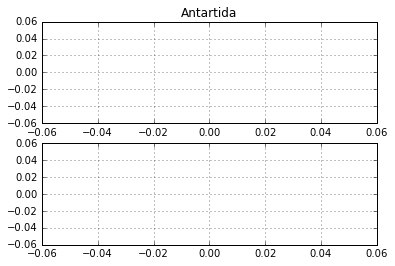

In [8]:
plt.figure(1)
df = df_total[df_total.continent=='antarctica']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Antartida')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

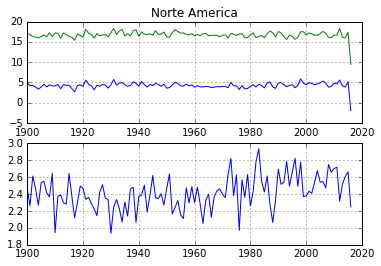

In [9]:
plt.figure(1)
df = df_total[df_total.continent=='north_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Norte America')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

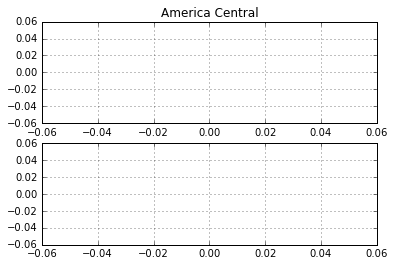

In [10]:
plt.figure(1)
df = df_total[df_total.continent=='central_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('America Central')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

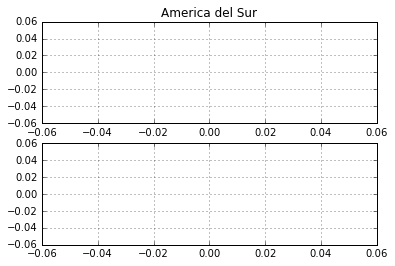

In [11]:
plt.figure(1)
df = df_total[df_total.continent=='south_america']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('America del Sur')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

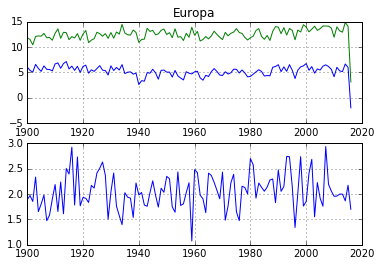

In [12]:
plt.figure(1)
df = df_total[df_total.continent=='europa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Europa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

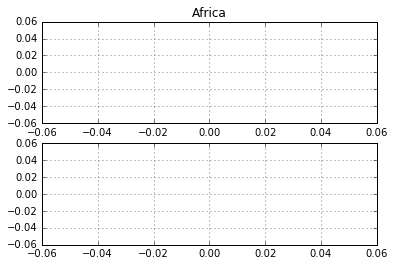

In [13]:
plt.figure(1)
df = df_total[df_total.continent=='africa']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Africa')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

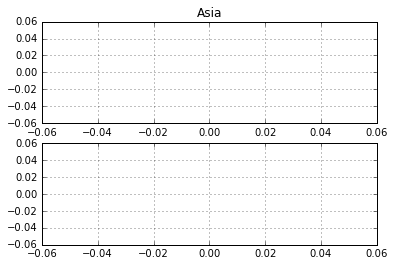

In [14]:
plt.figure(1)
df = df_total[df_total.continent=='asia']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Asia')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)

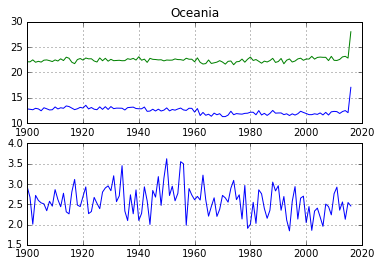

In [15]:
plt.figure(1)
df = df_total[df_total.continent=='oceania']
plt.subplot(211)
plt.plot(df.year,df.TMIN)
plt.plot(df.year,df.TMAX)
plt.grid(True)
plt.title('Oceania')

plt.subplot(212)
plt.plot(df.year,df.PRCP)
plt.grid(True)